# ML Data Analysis


Create `DataFrame`s from processed datasets.

In [40]:
%load_ext autoreload
%autoreload 2
from data.load import load_parquet

tempanomalies_df = load_parquet('tempanomalies')
land_cover_df = load_parquet('land_cover_types')
co2_df = load_parquet('co2')

print(tempanomalies_df.columns)
print(land_cover_df.columns)
print(co2_df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Index(['time', 'lat', 'lon', 'tempanomaly'], dtype='object')
Index(['time', 'band', 'lat', 'lon', 'land_cover_type', 'spatial_ref',
       'land_cover_type_name', 'geometry'],
      dtype='object')
Index(['sounding_id', 'xco2', 'time', 'lat', 'lon'], dtype='object')


Score: 0.1778231827697876
Coefficients: [ 0.00354563  0.01942292 -0.2389242  -0.96501289]


C:\Users\dmitr\AppData\Local\Temp\ipykernel_16352\3193699783.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['month'] = list(map(lambda t: t.to_pydatetime().month, t_df['time']))
C:\Users\dmitr\AppData\Local\Temp\ipykernel_16352\3193699783.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['season'] = list(map(lambda t: ((t % 12) // 3) + 1, t_df['month']))
C:\Users\dmitr\AppData\Local\Temp\ipykernel_16352\3193699783.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

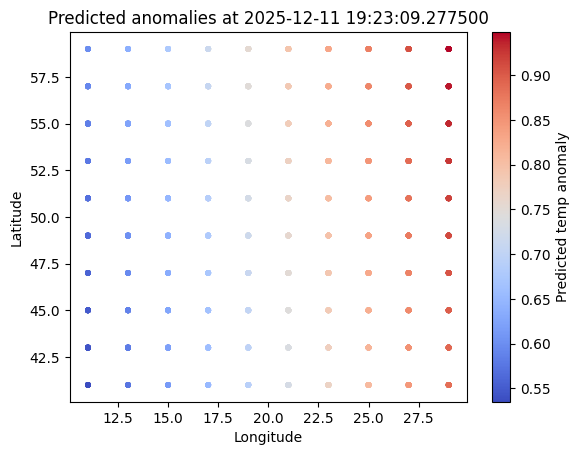

In [ ]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

t_df = tempanomalies_df.dropna(inplace = False)
t_df['month'] = list(map(lambda t: t.to_pydatetime().month, t_df['time']))
t_df['season'] = list(map(lambda t: ((t % 12) // 3) + 1, t_df['month']))
t_df['year'] = list(map(lambda t: t.to_pydatetime().year, t_df['time']))
t_df['month_sin'] = np.sin(2 * np.pi * t_df['month'] / 12)
t_df['month_cos'] = np.cos(2 * np.pi * t_df['month'] / 12)
t_df['time'] = list(map(lambda t: t.timestamp(), t_df['time']))

X = np.array(t_df[['lat', 'lon', 'month_sin', 'month_cos', 'year']])
y = np.array(t_df['tempanomaly'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print("Score:", reg.score(X_test, y_test))
print("Coefficients:", reg.coef_)

prediction_time = datetime.now() + timedelta(days=30)

future_points = pd.DataFrame({
    "lat": t_df['lat'],
    "lon": t_df['lon'],
    "month": [prediction_time.month]*len(t_df['lat']),
    "year": [prediction_time.year]*len(t_df['lat']),
    "season": [((prediction_time.month% 12) // 3) + 1]*len(t_df['lat']),
})

future_points["tempanomaly"] = reg.predict(future_points)
future_points["time"] = [prediction_time.timestamp()]*len(t_df['lat'])

plt.scatter(future_points["lon"], future_points["lat"], c=future_points["tempanomaly"], cmap="coolwarm", s=10)
plt.colorbar(label="Predicted temp anomaly")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Predicted anomalies at {prediction_time}")
plt.show()


In [47]:
from visualization.plotting import plot_temp_stats

merged = pd.concat([t_df, future_points], axis=0)

merged

,time,lat,lon,tempanomaly,month,season,year
0,1.705277e+09,41.0,11.0,2.300000,1,1.0,2024
1,1.705277e+09,41.0,13.0,2.810000,1,1.0,2024
2,1.705277e+09,41.0,15.0,2.470000,1,1.0,2024
3,1.705277e+09,41.0,17.0,2.120000,1,1.0,2024
4,1.705277e+09,41.0,19.0,2.500000,1,1.0,2024
...,...,...,...,...,...,...,...
1995,1.765477e+09,59.0,21.0,0.792932,12,NaN,2025
1996,1.765477e+09,59.0,23.0,0.831778,12,NaN,2025
1997,1.765477e+09,59.0,25.0,0.870624,12,NaN,2025
1998,1.765477e+09,59.0,27.0,0.909470,12,NaN,2025


c:\Users\dmitr\miniconda3\envs\climate_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  warnings.warn(


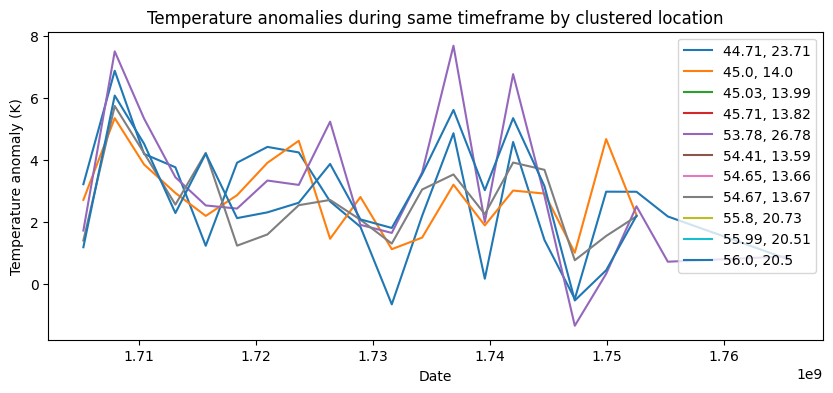

In [48]:
plot_temp_stats(merged, save = False)